 lowpass filter
 sample rate, fs=250.0 
 cutoff_hz = 10.0 
 width of transition, width=10 hz 
 ripple_db=60.0 
 FIR filter size: numtaps = 93, time = 0.372 s 
 delay = 46 , delay_time = 0.186 s


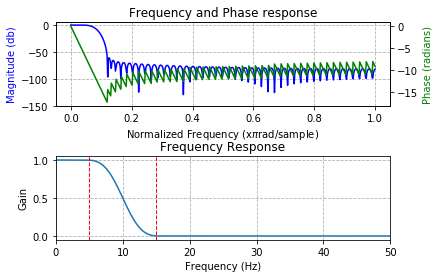

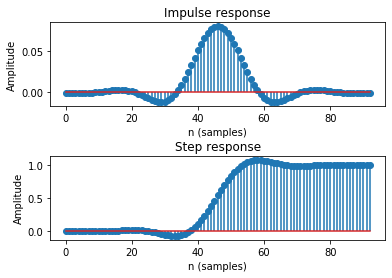

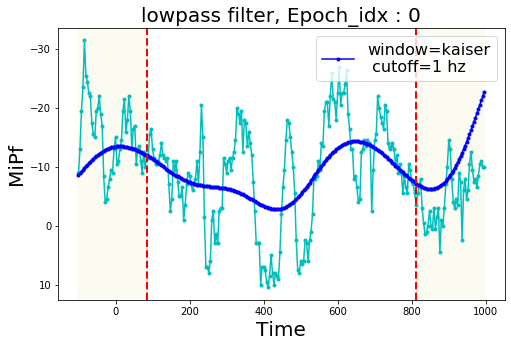

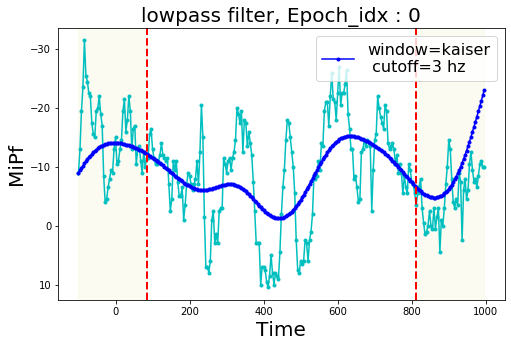

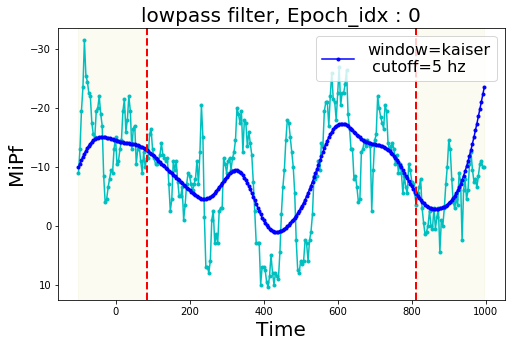

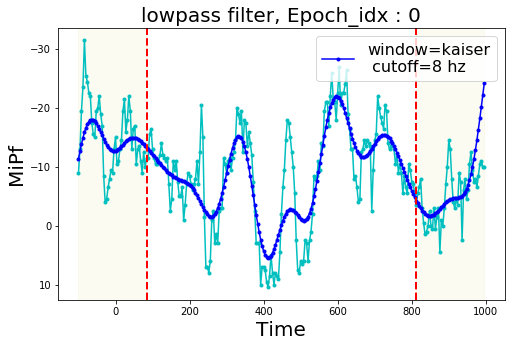

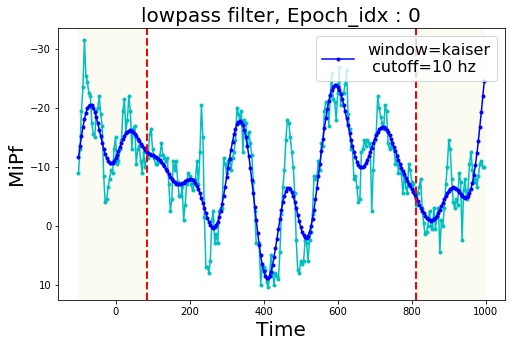

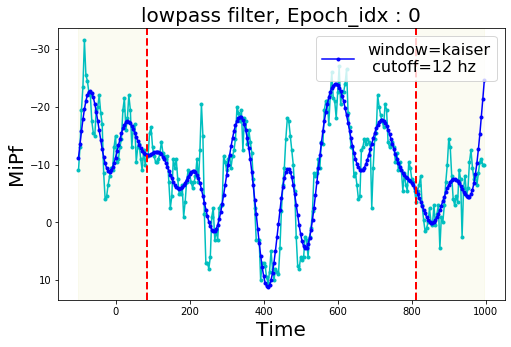

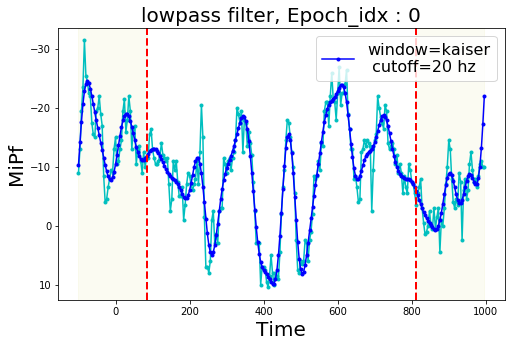

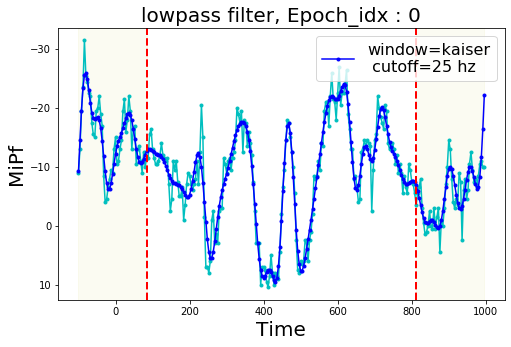

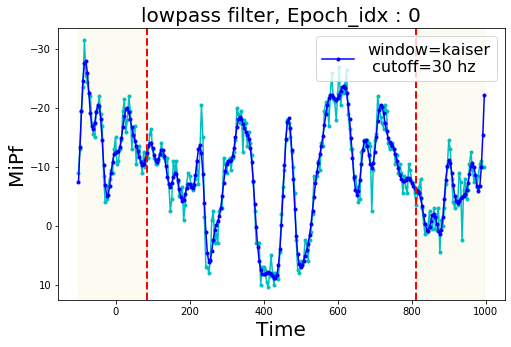

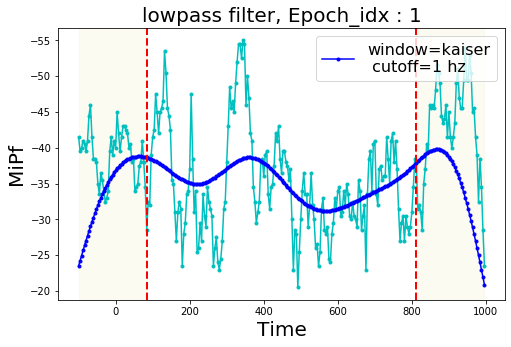

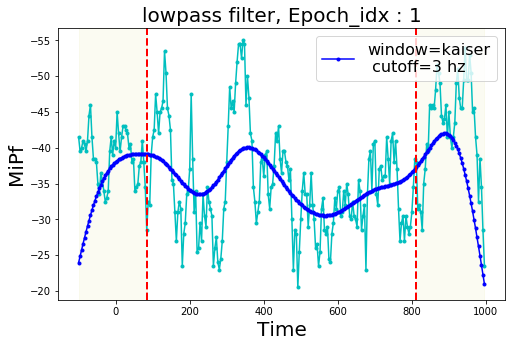

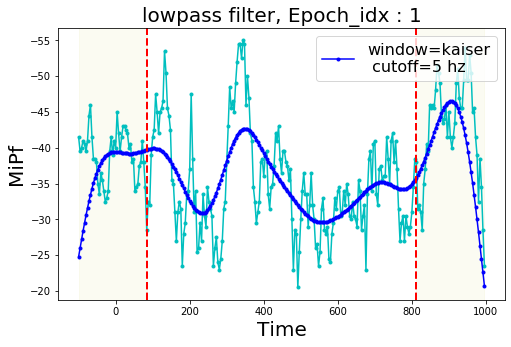

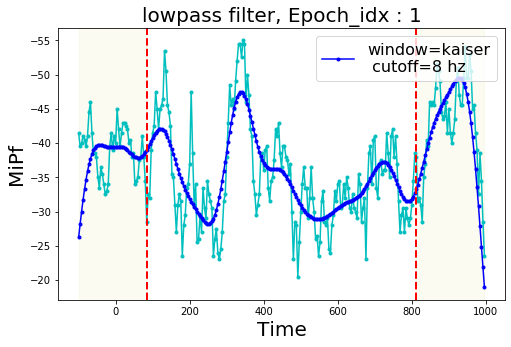

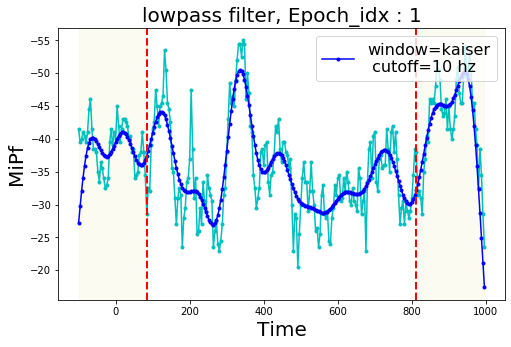

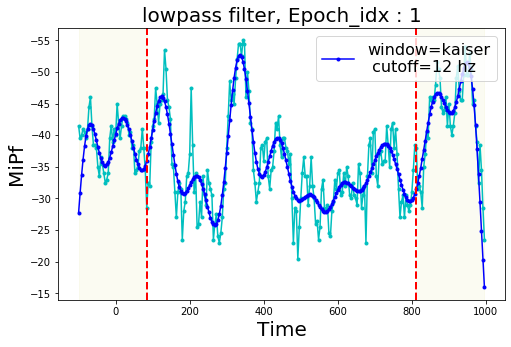

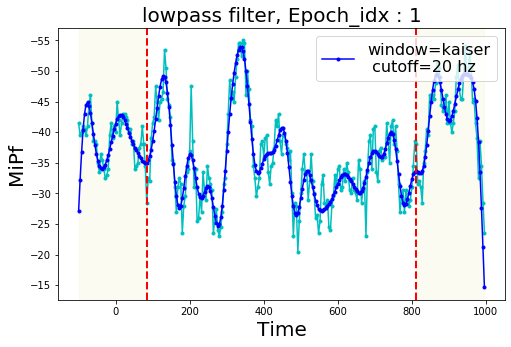

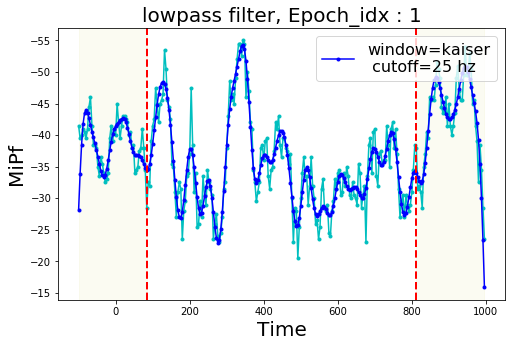

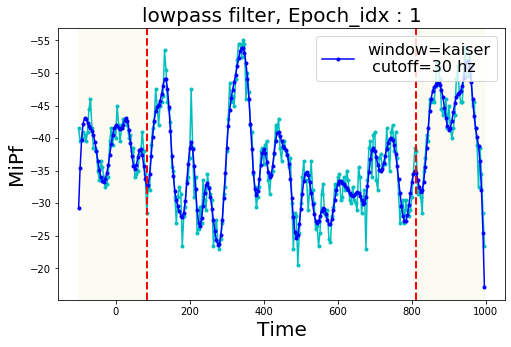

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal, fftpack
from pylab import *
import spudtr.filters as filters

import logging as LOGGER
from scipy.signal import kaiserord, firwin, freqz, lfilter

plt.clf()
plt.close('all')

cutoff_hz = 10.0 # 30.0
ftype = 'lowpass'  # 'highpass'
#ripple_db = 24.0 #60.0
#width_hz = 12
width_hz = 10
ripple_db = 60.0
sfreq = 250.0 # 500.0
#trim_edges = False
window = 'kaiser'
#window = 'blackman'
cutoff_list = [1,3,5,8,10,12,20,25,30]
#window_list = ['kaiser','hamming','hann','blackman']
window_list = ['kaiser']

wr = "/home/qiz001/zq/Projects/spudtr/tests/data/sub000wr.epochs.h5"
epochs_df = pd.read_hdf(wr, key='wr')
eeg_streams = ["MiPf", "MiCe", "MiPa", "MiOc"]

chan = 0
channel_id = chan

taps = filters._design_firwin_filter(cutoff_hz, width_hz, ripple_db, sfreq, ftype, window)
N = len(taps)

# print filter information
text1 = f" {ftype} filter"
print(text1)
text2 = f" sample rate, fs={sfreq} \n cutoff_hz = {cutoff_hz} \n width of transition, width={width_hz} hz \n ripple_db={ripple_db} \n FIR filter size: numtaps = {len(taps)}, time = {len(taps)/sfreq} s \n delay = {int((len(taps) - 1) / 2)} , delay_time = {len(taps)/(2*sfreq)} s"
print(text2)

fig1 = filters._mfreqz(taps,sfreq,cutoff_hz,width_hz,a=1)          
fig2 = filters._impz(taps,a=1)

for epoch_i in range(2):
      epoch1=epochs_df[epochs_df.Epoch_idx == epoch_i]
      for cutoff_hz in cutoff_list:
           fig, ax = plt.subplots(figsize=(8,5))
           for window in window_list:
               #trim_edges = True
               trim_edges = False

               filt_epochs_df = filters.epochs_filters(
                   epochs_df, eeg_streams, ftype, window, cutoff_hz, width_hz, ripple_db, sfreq, trim_edges
               )

               epoch2=filt_epochs_df[filt_epochs_df.Epoch_idx == epoch_i]

               y1=epoch1[eeg_streams].iloc[:,channel_id]
               y2=epoch2[eeg_streams].iloc[:,channel_id]
               t1 = epoch1['Time']
               t2 = epoch2['Time']
               num=epoch1.index.size

               ax.plot(t1,y1, '.-',  color= 'c', linestyle='-')
               ax.plot(t2,y2, '.-',  color= 'b', linestyle='-', label=f"window={window}\n cutoff={cutoff_hz} hz")
               half_width = int(np.floor(N / 2))
               times = filt_epochs_df.Time.unique()
               start_good = times[half_width]  # == first good sample b.c. 0-base index
               stop_good = times[-(half_width + 1)]
               ax.axvline(start_good, linestyle='--', linewidth=2, color='r')
               ax.axvspan(min(times), start_good, alpha=0.05, color='y')
               ax.axvline(stop_good, linestyle='--', linewidth=2, color='r')
               ax.axvspan(stop_good, max(times), alpha=0.05, color='y')  
               ax.invert_yaxis()
               
               ax.set_title(f"{ftype} filter, Epoch_idx : {epoch_i}", fontsize=20)
               ax.set_xlabel('Time', fontsize=20)
               ax.set_ylabel(eeg_streams[channel_id], fontsize=20)
               ax.legend(fontsize=16,loc=1)
               #ax.grid(True)

      plt.show()
